## 강의 Review


In [ ]:
# 영어 : CFG , (ex C, Java)
# 컴파일러에서 파스트리를 그리다가 실패하면 syntax error

# Bottom-up parsing algorithm : CKY

# Non-Terminal은 다른거로 바뀔 수 있는 터미널
# RHS에는 NT 와 T가 섞여서 와도 됨.

# CFG랑 CSG 중요 !! 시험에 나올 수 있음
# CFG는 문맥 고려 X
# CSG는 문맥 고려 O

# 전치사 때문에 많은 파스트리가 생성됨. (많은 해석이 존재하게 됨)

In [ ]:
# 나는 예쁜 꽃을 좋아한다.

# 1. 나는/스택  예쁜 꽃을 좋아한다./큐   Shift

# 스택의 top이 큐의 front를 꾸미나 -> 꾸미면 Reduce, 안꾸미면 Shift

## 실습

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys
import os
root_dir = "/content/drive/MyDrive/자연어처리/8-2. Syntactic Parsing"
sys.path.append(root_dir)

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


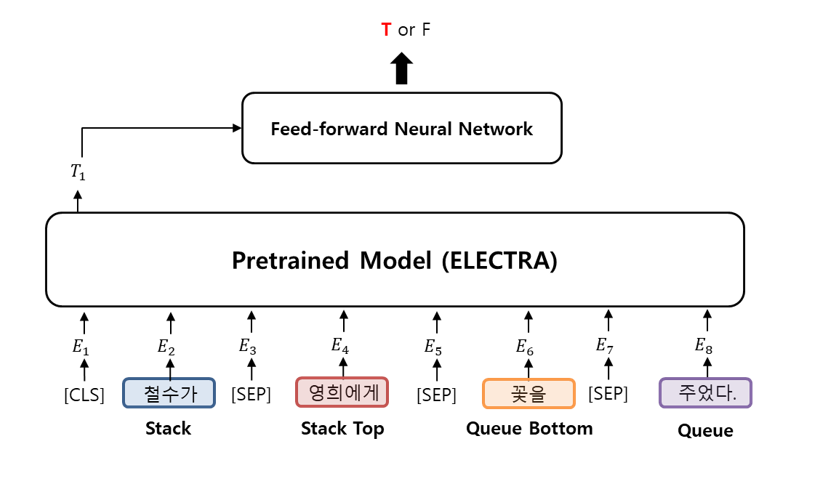

In [ ]:
from IPython.display import Image
Image(os.path.join(root_dir, "SyntacticParsing.JPG"))

In [ ]:
!pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn

from transformers import ElectraPreTrainedModel, ElectraModel

class ElectraForSequenceClassification(ElectraPreTrainedModel):

    def __init__(self, config):
        super(ElectraForSequenceClassification, self).__init__(config)

        # Electra 모델
        self.electra = ElectraModel(config)

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels  # num_labels = 2 (Shift or Reduce)

        self.hidden_size = config.hidden_size
        self.output_layer = nn.Linear(in_features=self.hidden_size, out_features=self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        # token_type_ids : stack, top, front, queue를 구분하는 토큰을 지정해줄 수 있음.

        # electra_output : (batch_size, max_length, hidden_size)
        electra_output = outputs[0] # Electra의 맨 마지막 계층

        # cls_vector : (batch_size, hidden_size)
        cls_vector = electra_output[:, 0, :]  # 0번째인 CLS만 가져오기

        # outputs : (batch_size, num_labels)
        outputs = self.output_layer(cls_vector)

        return outputs

In [ ]:
import torch
import numpy as np
import re
from tqdm import tqdm

from konlpy.tag import Komoran
komoran = Komoran()


label2idx = {"1":1, "0":0}
idx2label = {1:'1', 0:'0'}
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as infile:
        datas = []
        for line in infile:
            # 입력 데이터를 #%#을 기준으로 분리
            pieces = line.strip().split("#%#")

            # # 입력 데이터 품사 태깅
            # for i in range(4):
            #     tagged_words_formatted = []
            #     pieces[i] = komoran.pos(pieces[i])
            #     for word, tag in pieces[i]:
            #         tagged_words_formatted.append(f"{word}/{tag}")
            #     pieces[i] = ' '.join(tagged_words_formatted)

            stack, top, bottom, queue, label = pieces[0], pieces[1], pieces[2], pieces[3], pieces[4]
            datas.append((stack, top, bottom, queue, label))
    return datas


def convert_data2feature(datas, max_length, tokenizer, label2idx):
    input_ids_features, attention_mask_features, token_type_ids_features, label_id_features = [], [], [], []

    for stack, stack_top, queue_front, queue, label in tqdm(datas, desc="convert_data2feature"):
        # Electra tokenizer를 사용하여 입력 문장을 word piece 단위로 분리
        tokenized_stack = tokenizer.tokenize(stack)
        tokenized_stack_top = tokenizer.tokenize(stack_top)
        tokenized_queue_front = tokenizer.tokenize(queue_front)
        tokenized_queue = tokenizer.tokenize(queue)

        # CLS, SEP 토큰 추가
        tokens = [tokenizer.cls_token]
        tokens += tokenized_stack
        tokens += [tokenizer.sep_token]

        tokens += tokenized_stack_top
        tokens += [tokenizer.sep_token]

        tokens += tokenized_queue_front
        tokens += [tokenizer.sep_token]

        tokens += tokenized_queue
        tokens += [tokenizer.sep_token]


        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)[:max_length]
        # padding을 제외한 실제 데이터 정보를 반영해주기 위한 attention mask
        attention_mask = [1] * len(input_ids) # attention을 계산할 범위 지정
        # 각 문장을 구분하기 위한 정보를 반영해주기 위한 token type
        # token_type_ids = [0] * len(input_ids)

        # token_type_ids 으로 stack, stack top, queue front, queue를 구분
        token_type_ids = []
        token_type_ids += [0] * (len(tokenized_stack)+2)
        token_type_ids += [0] * (len(tokenized_stack_top)+1)
        token_type_ids += [1] * (len(tokenized_queue_front)+1)
        token_type_ids += [1] * (len(tokenized_queue)+1)


        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids)) # [PAD]의 ids는 0
        input_ids += padding
        attention_mask += padding
        token_type_ids += padding
        assert max_length == len(input_ids) == len(attention_mask) == len(token_type_ids) # assert는 계산된 길이가 맞는지 검사

        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        attention_mask_features.append(attention_mask)
        token_type_ids_features.append(token_type_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    token_type_ids_features = torch.tensor(token_type_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, token_type_ids_features, label_id_features

In [ ]:
import os
import numpy as np
from tqdm import tqdm


import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim

from transformers import ElectraPreTrainedModel, ElectraTokenizer, ElectraConfig
from sklearn.metrics import accuracy_score

def train(config):
    # Electra tokenizer 객체 생성
    electra_tokenizer = ElectraTokenizer.from_pretrained(config['pretrained_model_name_or_path'])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features = \
        convert_data2feature(train_datas, config["max_length"], electra_tokenizer, label2idx)
    test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
        convert_data2feature(test_datas, config["max_length"], electra_tokenizer, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # 사전 학습된 Electra 모델 파일로부터 가중치 불러옴
    electra_config = ElectraConfig.from_pretrained(config['pretrained_model_name_or_path'])
    # electra_config의 type_vocab_size를 변경
    # setattr(electra_config, 'type_vocab_size', config['type_vocab_size'])

    model = ElectraForSequenceClassification.from_pretrained(config['pretrained_model_name_or_path'], config=electra_config, ignore_mismatched_sizes=True).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-5)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    global_step = 0
    for epoch in range(config["epoch"]):
        model.train()

        total_loss = []
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            if (global_step + 1) % 10 == 0:
                print("Current {} Step Loss : {}".format(global_step+1, loss))
            if (global_step+1) % 200 == 0:
                electra_config.save_pretrained(save_directory=config["output_dir_path"]) # 하이퍼 파라미터(config.json 파일 저장)
                model.save_pretrained(save_directory=config["output_dir_path"])         # 학습된 ELECTRA 모델 파라미터 저장
                max_accuracy = evaluate(model, electra_tokenizer, test_dataloader, step, max_accuracy)
            global_step += 1
def evaluate(model, tokenizer, test_dataloader=None, global_step=0, max_accuracy=0):
    if not test_dataloader:
        test_datas = read_data(config["test_data_path"])

        # 입력 데이터 전처리
        test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
            convert_data2feature(test_datas, config["max_length"], tokenizer, label2idx)

        # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        test_features = TensorDataset(test_input_ids_features, test_attention_mask_features,
                                      test_token_type_ids_features, test_label_id_features)
        test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                     batch_size=config["batch_size"])
    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_hypothesis, total_labels = [], []
    for idx, batch in enumerate(test_dataloader):
        batch = tuple(t.cuda() for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            # hypothesis : (batch_size, num_labels)
            hypothesis = model(input_ids, attention_mask, token_type_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(hypothesis, dim=-1)   # 맨 마지막 차원(num_labels)이 기준 !

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        total_hypothesis += hypothesis
        total_labels += label_id

        if idx < 10:
            input_ids = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
            input_sequence = tokenizer.convert_tokens_to_string(input_ids[1:input_ids.index(tokenizer.pad_token)] if tokenizer.pad_token in input_ids else input_ids[1:])
            stack, top, front, queue, _ = [e.strip() for e in input_sequence.split("[SEP]")]
            print("\nStack : ", stack)
            print("Stack Top : ", top)
            print("Queue front : ", front)
            print("Queue : ", queue)
            print("Prediction : ", hypothesis[0])
            print("Label : ", label_id[0], '\n\n')

    # 정확도 계산
    accuracy = accuracy_score(total_labels, total_hypothesis)
    print("Accuracy : {}".format(accuracy))

    return accuracy

## 성능 개선

In [ ]:
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)

import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "pretrained_model_name_or_path": "monologg/koelectra-small-v3-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 250,
              "epoch": 4,
              "batch_size": 64,
            #   "type_vocab_size" : 3
              }

    if (config["mode"] == "train"):
        train(config)
    elif config["mode"] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"], config=electra_config).cuda()
        evaluate(model, tokenizer)

convert_data2feature: 100%|██████████| 25838/25838 [00:09<00:00, 2718.24it/s]
Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model che

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Current 5310 Step Loss : 0.08680674433708191
Current 5320 Step Loss : 0.17160126566886902
Current 5330 Step Loss : 0.04946624115109444
Current 5340 Step Loss : 0.07627005875110626
Current 5350 Step Loss : 0.05041591078042984
Current 5360 Step Loss : 0.03456385061144829
Current 5370 Step Loss : 0.11067201942205429
Current 5380 Step Loss : 0.10540168732404709
Current 5390 Step Loss : 0.05595061928033829
Current 5400 Step Loss : 0.08918329328298569

Stack :  
Stack Top :  인천지역에
Queue front :  11층
Queue :  이상 고층 건축물은 아파트 3887개동과 일반 건축물 등 총 4064개동이다 .
Prediction :  0
Label :  0 



Stack :  이 사전은 해당 단어와 같은 의미로
Stack Top :  사용되는
Queue front :  동의어까지
Queue :  함께 찾아준다 .
Prediction :  1
Label :  1 



Stack :  아시아 경제위기 , 외환위기가 발생한 직후에도
Stack Top :  그는
Queue front :  경고를
Queue :  날렸다 .
Prediction :  0
Label :  0 



Stack :  
Stack Top :  그는
Queue front :  있는
Queue :  만큼 이 문제만 극복된다면 한국의 투자 매력도는 굉장히 올라갈 것 ” 이라고 덧붙였다 .
Prediction :  0
Label :  0 



Stack :  한화 

In [ ]:
# token_type_ids
# 입력에 POS 태깅 추가해보기

In [ ]:
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)

import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "test",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "pretrained_model_name_or_path": "monologg/koelectra-small-v3-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 250,
              "epoch": 4,
              "batch_size": 64,
            #   "type_vocab_size" : 3
              }

    if (config["mode"] == "train"):
        train(config)
    elif config["mode"] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"], config=electra_config).cuda()
        evaluate(model, tokenizer)

convert_data2feature: 100%|██████████| 25838/25838 [00:10<00:00, 2560.04it/s]



Stack :  
Stack Top :  인천지역에
Queue front :  11층
Queue :  이상 고층 건축물은 아파트 3887개동과 일반 건축물 등 총 4064개동이다 .
Prediction :  0
Label :  0 



Stack :  이 사전은 해당 단어와 같은 의미로
Stack Top :  사용되는
Queue front :  동의어까지
Queue :  함께 찾아준다 .
Prediction :  1
Label :  1 



Stack :  아시아 경제위기 , 외환위기가 발생한 직후에도
Stack Top :  그는
Queue front :  경고를
Queue :  날렸다 .
Prediction :  0
Label :  0 



Stack :  
Stack Top :  그는
Queue front :  있는
Queue :  만큼 이 문제만 극복된다면 한국의 투자 매력도는 굉장히 올라갈 것 ” 이라고 덧붙였다 .
Prediction :  0
Label :  0 



Stack :  한화 측은 “ 자금 조달 계획에 최대한 성의를 보였는데 산은은 수정안에 대해 자산가격을 조정하는 등의 협상도 하지 않은 채 일방적으로 공문만
Stack Top :  보냈다 ” 며
Queue front :  팔
Queue :  의지가 있는지 의심스럽다 ” 고 말했다 .
Prediction :  0
Label :  0 



Stack :  맨살이 드러나는 건 얼굴밖에
Stack Top :  없지만
Queue front :  선수들의
Queue :  건강미를 감상한다 .
Prediction :  0
Label :  0 



Stack :  “ 두딸이 ‘ 돌아올수
Stack Top :  없는
Queue front :  문 ’
Queue :  오가는 모습 못잊어 ”
Prediction :  1
Label :  1 



Stack :  北 개성관광만 빼고 ‘ 12 · 1조치 ’
Stack Top :  모두
Queue front :  철회
Queue :  
Predict

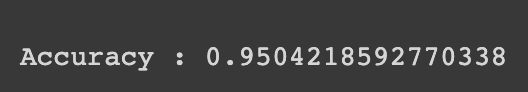

##**0.947 -> 0.9504**  
먼저 제가 성능을 향상시키기 위해 시도한 방법은 크게 두 가지 입니다.  
1. token_type_ids를 통해 stack, top, front, queue를 구분
2. Syntactic Parsing을 진행하기 전, POS Tagging을 진행

**1번 방법**은 각각의 token_type_ids를 1,2,3,4로 부여하는 방법과 0,0,1,1로 부여하는 방법을 시도해보았습니다.   
1,2,3,4로 부여할 경우 기존 electra 모델의 type_vocab_size와 임베딩 사이즈가 맞지 않아 에러가 발생하였고, 이를 setattr을 통해 config를 수정해주는 방향으로 시도하였습니다.  
하지만 성능개선이 이뤄지지 않았습니다.   
문장 내부를 구분하는 중요한 지점은 stack top 부분과 queue front 부분이라 생각되어  
stack, top, front, queue 를 각각 0, 0, 1, 1로 지정해주었습니다.  
이를 통해 기존성능 0.947에서 0.9504로 향상시킬 수 있었습니다.

**2번 방법**은 POS Tagging을 먼저 진행한 후 Sytactic Parsing을 하면 성능 향상에 도움이 될 수 있다 판단하여 시도해보았으나, POS Tagging을 한 뒤 Tokening을 하는 과정에서 해결책을 찾지 못해 끝내 결과를 내보지는 못하였습니다.




## .

## .

## 기존 성능

In [ ]:
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)

import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "pretrained_model_name_or_path": "monologg/koelectra-small-v3-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 250,
              "epoch": 4,
              "batch_size": 64,
              }

    if (config["mode"] == "train"):
        train(config)
    elif config["mode"] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"], config=electra_config).cuda()
        evaluate(model, tokenizer)

convert_data2feature: 100%|██████████| 25838/25838 [00:11<00:00, 2226.83it/s]
Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model che

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Current 5310 Step Loss : 0.08574508875608444
Current 5320 Step Loss : 0.16763503849506378
Current 5330 Step Loss : 0.06814294308423996
Current 5340 Step Loss : 0.0870564803481102
Current 5350 Step Loss : 0.06453267484903336
Current 5360 Step Loss : 0.03920552507042885
Current 5370 Step Loss : 0.09417812526226044
Current 5380 Step Loss : 0.047797251492738724
Current 5390 Step Loss : 0.0788368359208107
Current 5400 Step Loss : 0.1063588410615921

Stack :  
Stack Top :  인천지역에
Queue front :  11층
Queue :  이상 고층 건축물은 아파트 3887개동과 일반 건축물 등 총 4064개동이다 .
Prediction :  0
Label :  0 



Stack :  이 사전은 해당 단어와 같은 의미로
Stack Top :  사용되는
Queue front :  동의어까지
Queue :  함께 찾아준다 .
Prediction :  1
Label :  1 



Stack :  아시아 경제위기 , 외환위기가 발생한 직후에도
Stack Top :  그는
Queue front :  경고를
Queue :  날렸다 .
Prediction :  0
Label :  0 



Stack :  
Stack Top :  그는
Queue front :  있는
Queue :  만큼 이 문제만 극복된다면 한국의 투자 매력도는 굉장히 올라갈 것 ” 이라고 덧붙였다 .
Prediction :  0
Label :  0 



Stack :  한화 측은

In [ ]:
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)

import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "test",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "pretrained_model_name_or_path": "monologg/koelectra-small-v3-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 250,
              "epoch": 4,
              "batch_size": 64,
              }

    if (config["mode"] == "train"):
        train(config)
    elif config["mode"] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"], config=electra_config).cuda()
        evaluate(model, tokenizer)

convert_data2feature: 100%|██████████| 25838/25838 [00:10<00:00, 2451.30it/s]



Stack :  
Stack Top :  인천지역에
Queue front :  11층
Queue :  이상 고층 건축물은 아파트 3887개동과 일반 건축물 등 총 4064개동이다 .
Prediction :  0
Label :  0 



Stack :  이 사전은 해당 단어와 같은 의미로
Stack Top :  사용되는
Queue front :  동의어까지
Queue :  함께 찾아준다 .
Prediction :  1
Label :  1 



Stack :  아시아 경제위기 , 외환위기가 발생한 직후에도
Stack Top :  그는
Queue front :  경고를
Queue :  날렸다 .
Prediction :  0
Label :  0 



Stack :  
Stack Top :  그는
Queue front :  있는
Queue :  만큼 이 문제만 극복된다면 한국의 투자 매력도는 굉장히 올라갈 것 ” 이라고 덧붙였다 .
Prediction :  0
Label :  0 



Stack :  한화 측은 “ 자금 조달 계획에 최대한 성의를 보였는데 산은은 수정안에 대해 자산가격을 조정하는 등의 협상도 하지 않은 채 일방적으로 공문만
Stack Top :  보냈다 ” 며
Queue front :  팔
Queue :  의지가 있는지 의심스럽다 ” 고 말했다 .
Prediction :  0
Label :  0 



Stack :  맨살이 드러나는 건 얼굴밖에
Stack Top :  없지만
Queue front :  선수들의
Queue :  건강미를 감상한다 .
Prediction :  0
Label :  0 



Stack :  “ 두딸이 ‘ 돌아올수
Stack Top :  없는
Queue front :  문 ’
Queue :  오가는 모습 못잊어 ”
Prediction :  1
Label :  1 



Stack :  北 개성관광만 빼고 ‘ 12 · 1조치 ’
Stack Top :  모두
Queue front :  철회
Queue :  
Predict

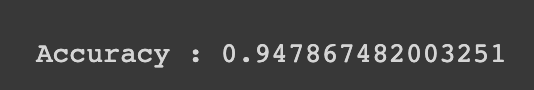